<a href="https://colab.research.google.com/github/ro1238b/CODSOFT/blob/main/saleforecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
df = pd.read_csv(r'/content/train.csv')
df.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [3]:
test_df=pd.read_csv(r'/content/test.csv')
test_df.head()

,id,date,store,item
0,0,2018-01-01,1,1
1,1,2018-01-02,1,1
2,2,2018-01-03,1,1
3,3,2018-01-04,1,1
4,4,2018-01-05,1,1


In [4]:
df.isnull().sum()

,0
date,0
store,0
item,0
sales,0


In [5]:
test_df.isnull().sum()

,0
id,0
date,0
store,0
item,0


In [6]:
df['date'] = pd.to_datetime(df['date'])
test_df['date'] = pd.to_datetime(test_df['date'])

In [7]:
# Sort values (important for time series)
df = df.sort_values(by=['store', 'item', 'date']).reset_index(drop=True)
test_df = test_df.sort_values(by=['store', 'item', 'date']).reset_index(drop=True)

In [8]:
#Time features
def add_time_features(df):
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['dayofweek'] = df['date'].dt.dayofweek
    df['weekofyear'] = df['date'].dt.isocalendar().week
    df['is_weekendf'] = df['dayofweek'].apply(lambda x: 1 if x >= 5 else 0)
    df['quarter'] = ((df['month']-1) // 3 + 1)

#cyclical features
    df['day_sin']=np.sin(2 * np.pi * df['dayofweek']/7)
    df['day_cos']=np.cos(2 * np.pi * df['dayofweek']/7)
    df['month_sin']=np.sin(2 * np.pi * (df['month']-1)/12)
    df['month_cos']=np.cos(2 * np.pi * (df['month']-1)/12)
    return df

df = add_time_features(df)
test_df = add_time_features(test_df)

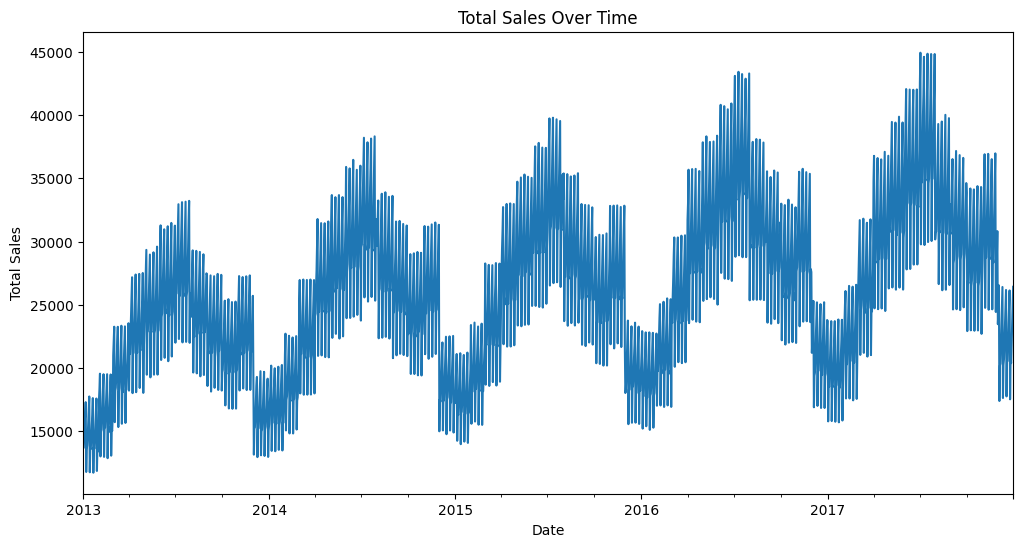

In [9]:
plt.figure(figsize=(12, 6))
df.groupby('date')['sales'].sum().plot()
plt.title('Total Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.show()

**seasonality :- there is regular spikes and drop each year ,likely weekly seasonality sales increase on certain days and drop on others, there may be also yearly seasonality  peak at the end of each year.**

**short term fluctuation is visible due to promotion , stock changes or special events**

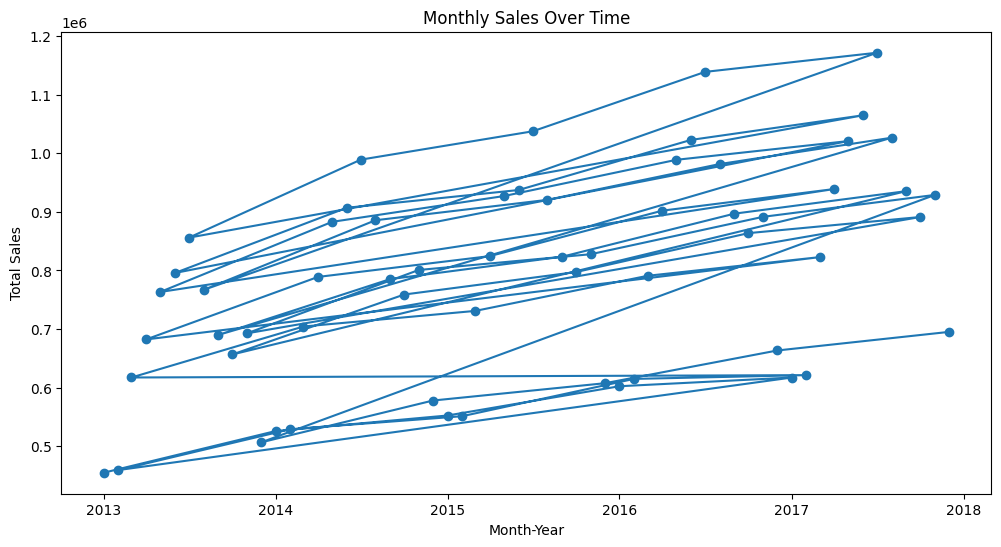

In [10]:
monthly_sales = df.groupby(['month','year'])['sales'].sum().reset_index()
monthly_sales['month_year'] = pd.to_datetime(monthly_sales[['year', 'month']].assign(DAY=1))

plt.figure(figsize=(12, 6))
plt.plot(monthly_sales['month_year'], monthly_sales['sales'], marker='o')
plt.title('Monthly Sales Over Time')
plt.xlabel('Month-Year')
plt.ylabel('Total Sales')
plt.show()

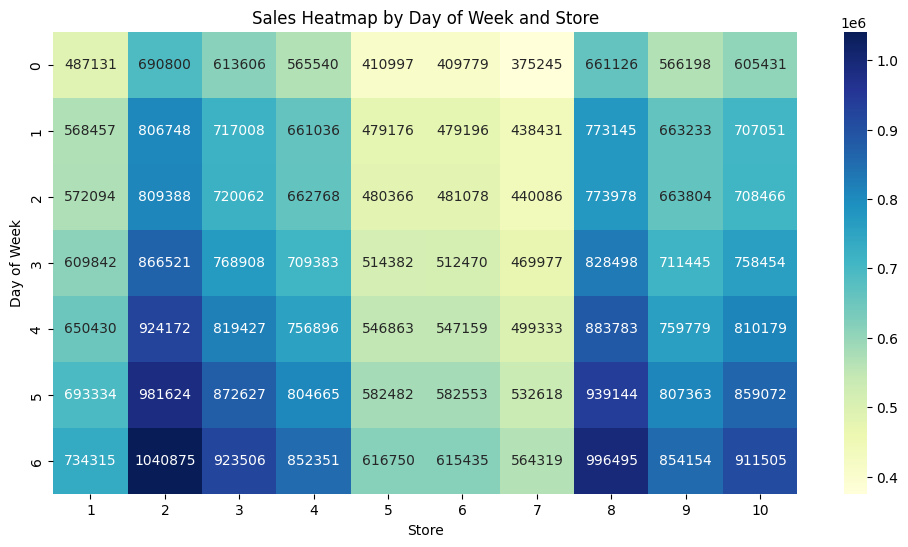

In [11]:
pivot_table = df.pivot_table(values='sales', index='dayofweek', columns='store', aggfunc='sum', fill_value=0)
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_table, annot=True, fmt=".0f", cmap="YlGnBu")
plt.title('Sales Heatmap by Day of Week and Store')
plt.xlabel('Store')
plt.ylabel('Day of Week')
plt.show()

In [12]:
print("number of unique stores:", df['store'].nunique())

number of unique stores: 10


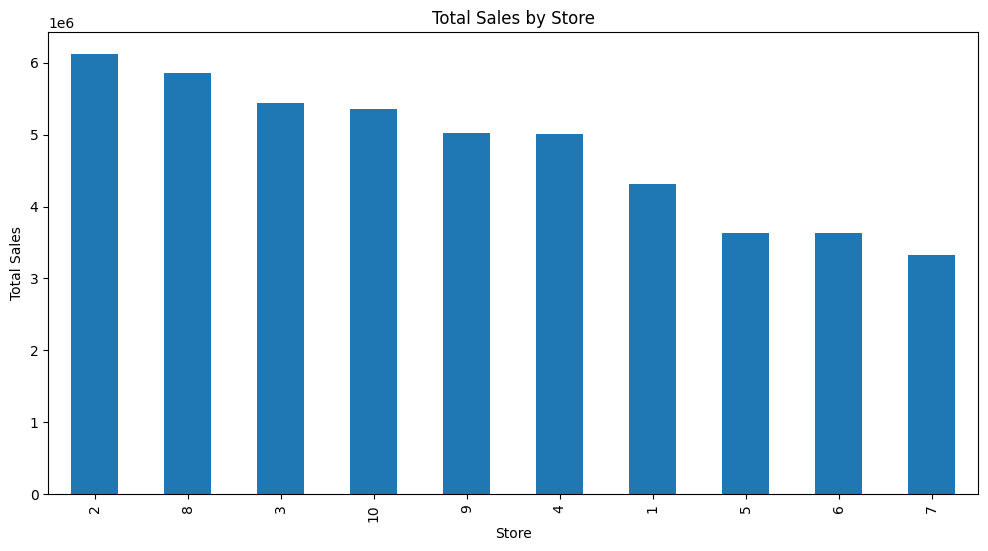

In [13]:
store_sales=df.groupby('store')['sales'].sum().sort_values(ascending=False)
plt.figure(figsize=(12, 6))
store_sales.plot(kind='bar')
plt.title('Total Sales by Store')
plt.xlabel('Store')
plt.ylabel('Total Sales')
plt.show()

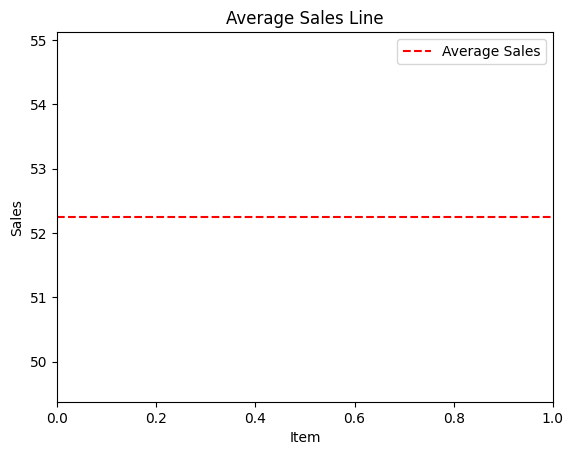

In [14]:
avg_sales_item=df['sales'].mean()
plt.axhline(y=avg_sales_item, color='r', linestyle='--', label='Average Sales')
plt.title('Average Sales Line')
plt.xlabel('Item')
plt.ylabel('Sales')
plt.legend()
plt.show()

<Axes: xlabel='store', ylabel='sales'>

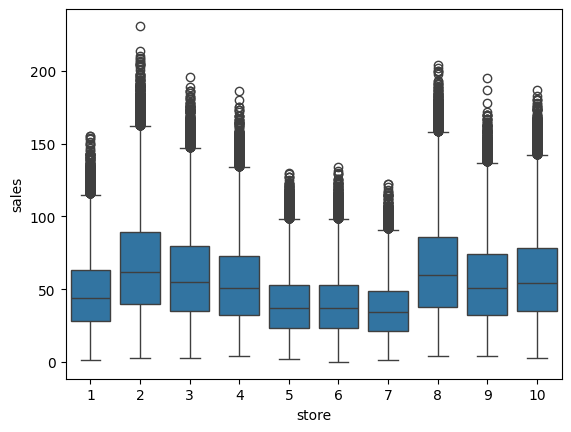

In [15]:
sns.boxplot(x='store', y='sales', data=df)

# **insights from box plot** #
*central tendency and spread*:- store 2 is a highest median sales with a median around 90 and also exhibits the highest IQR range. store 5,6,7 have the lowest median

In [16]:

groups=[group["sales"].values for name, group in df.groupby("store")]

f_stat, p_value = stats.f_oneway(*groups)

print("F-statistic:", f_stat)
print("P-value:", p_value)

F-statistic: 14848.920143263727
P-value: 0.0


In [17]:
tukey = pairwise_tukeyhsd(endog=df['sales'], groups=df['store'], alpha=0.05)
print(tukey)

 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1 group2 meandiff p-adj   lower    upper   reject
------------------------------------------------------
     1      2  19.7648    0.0  19.3665  20.1631   True
     1      3  12.2622    0.0  11.8639  12.6605   True
     1      4   7.6346    0.0   7.2363   8.0329   True
     1      5  -7.4982    0.0  -7.8965  -7.0999   True
     1      6  -7.5349    0.0  -7.9332  -7.1366   True
     1      7 -10.9046    0.0  -11.303 -10.5063   True
     1      8  16.8737    0.0  16.4754   17.272   True
     1      9   7.7806    0.0   7.3823    8.179   True
     1     10  11.4409    0.0  11.0426  11.8392   True
     2      3  -7.5026    0.0  -7.9009  -7.1043   True
     2      4 -12.1302    0.0 -12.5285 -11.7319   True
     2      5  -27.263    0.0 -27.6613 -26.8647   True
     2      6 -27.2996    0.0  -27.698 -26.9013   True
     2      7 -30.6694    0.0 -31.0677 -30.2711   True
     2      8  -2.8911    0.0  -3.2894  -2.4928   True
     2    

In [18]:
print("number of items", df['item'].nunique())

number of items 50


In [19]:
print("number of unique items:", test_df['item'].nunique())

number of unique items: 50


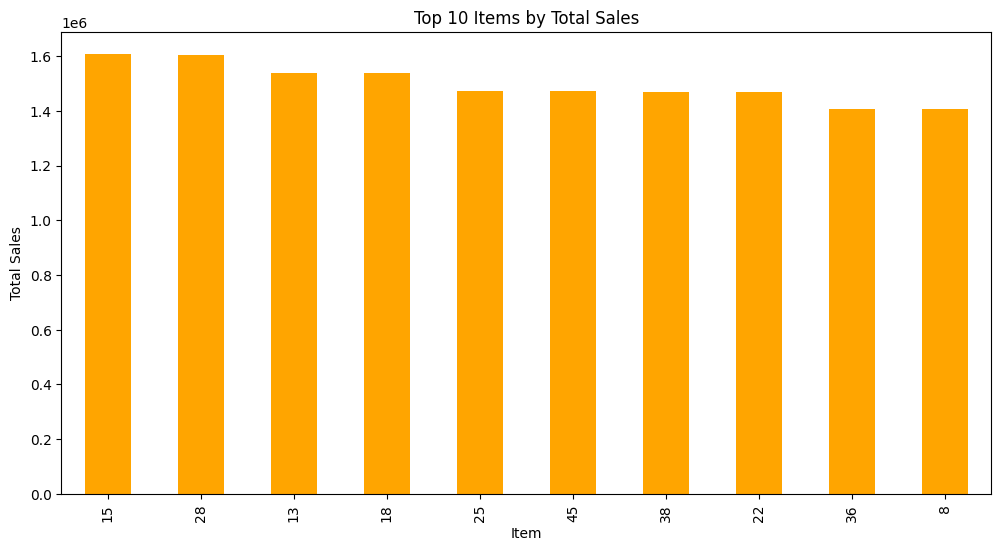

In [20]:
#TOP ITEMS
item_sales=df.groupby('item')['sales'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(12, 6))
item_sales.plot(kind='bar', color='orange')
plt.title('Top 10 Items by Total Sales')
plt.xlabel('Item')
plt.ylabel('Total Sales')
plt.show()


In [21]:
def create_lag_features(data, lags=[1, 7, 30, 365]):
    for lag in lags:
        data[f'lag_{lag}'] = data.groupby(['store', 'item'])['sales'].shift(lag)
        data[f'rolling_mean_{lag}'] = data.groupby(['store', 'item'])['sales'].transform(lambda x: x.shift(1).rolling(lag).mean())
    data.fillna(0, inplace=True)
    return data

In [22]:
df=create_lag_features(df)

In [23]:
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

corr_matrix = df[numeric_cols].corr()

corr_with_sales = corr_matrix['sales'].sort_values(ascending=False)
print(corr_with_sales)

sales               1.000000
lag_7               0.927097
rolling_mean_7      0.923366
rolling_mean_30     0.910040
rolling_mean_1      0.878551
lag_1               0.878551
lag_30              0.822845
lag_365             0.718630
rolling_mean_365    0.675135
is_weekendf         0.179098
month_sin           0.012761
store              -0.008170
item               -0.055998
day_cos            -0.068993
day_sin            -0.157222
month_cos          -0.306658
Name: sales, dtype: float64


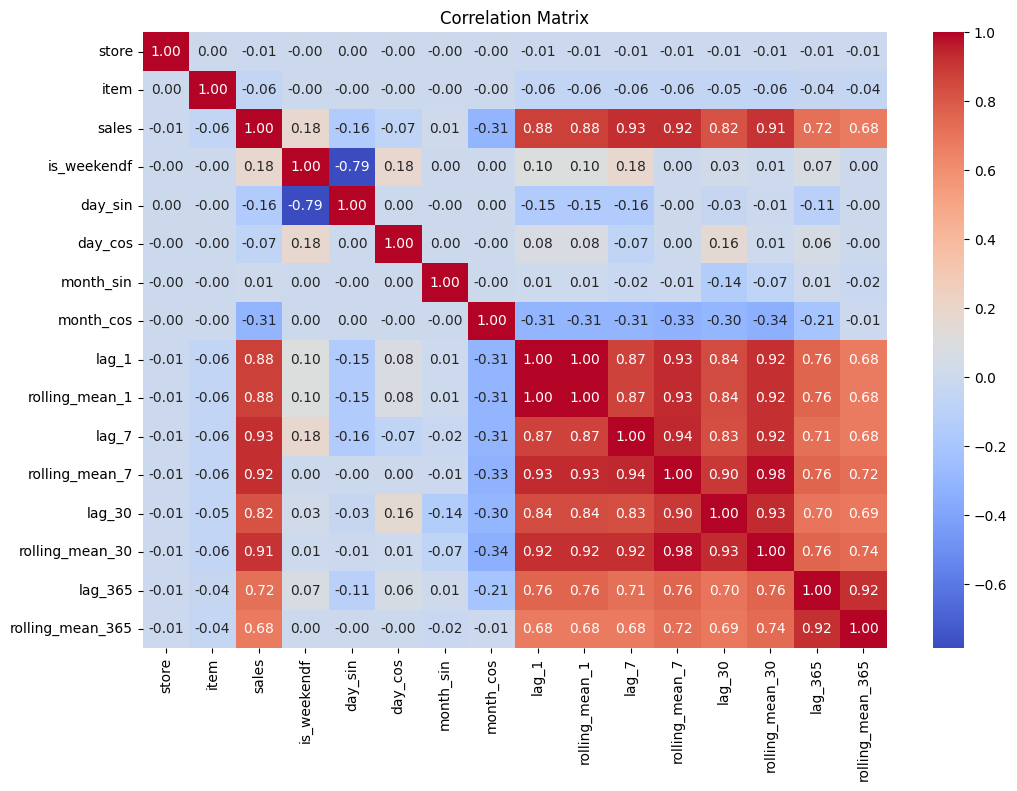

In [24]:
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title('Correlation Matrix')
plt.show()

In [25]:
from xgboost import XGBRegressor, plot_importance

X = df.drop(columns=['sales', 'date'])  # Features
y = df['sales']  # Target variable

model=XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
model.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

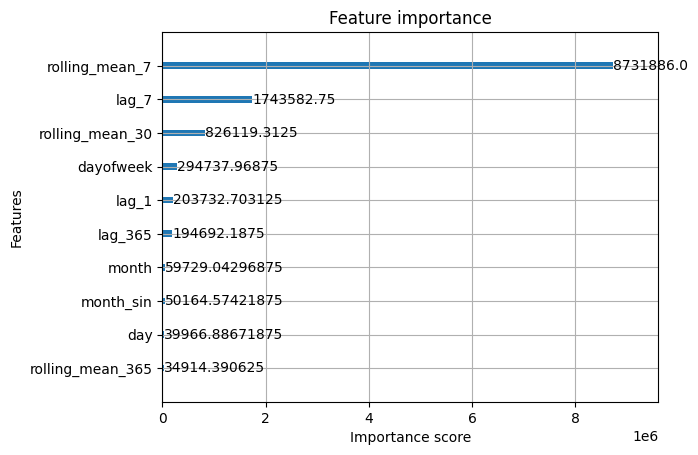

In [26]:
plot_importance(model,importance_type='gain',max_num_features=10)
plt.show()

In [27]:
import shap
explainer = shap.Explainer(model)
shap_values = explainer(X)

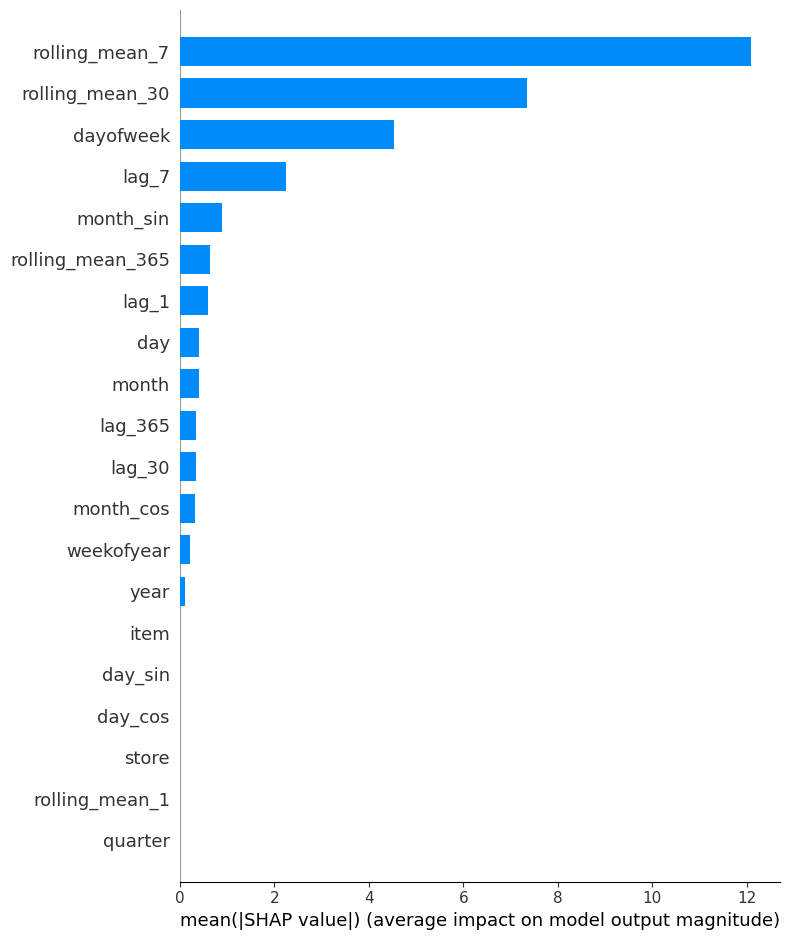

In [28]:
shap.summary_plot(shap_values, X, plot_type="bar")

In [29]:
val_days=90
X_train = df.drop(columns=['sales', 'date']).iloc[:-val_days]
y_train = df['sales'].iloc[:-val_days]

X_val = df.drop(columns=['sales', 'date']).iloc[-val_days:]
y_val = df['sales'].iloc[-val_days:]

In [30]:
from xgboost import XGBRegressor

# Define the XGBoost model with early_stopping_rounds in the constructor
xgb_model = XGBRegressor(
    n_estimators=5000,
    learning_rate=0.01,
    max_depth=9,
    subsample=0.7,
    colsample_bytree=0.7,
    reg_alpha=0.5,
    reg_lambda=0.5,
    random_state=42,
    eval_metric="rmse",
    tree_method='hist',
    early_stopping_rounds=100  # Moved here
)

# Fit the model
xgb_model.fit(
    X_train,
    y_train,
    eval_set=[(X_val, y_val)],
    verbose=False  # Set verbose to True for progress updates, False to be silent
)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=100,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=9,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=5000,
             n_jobs=None, num_parallel_tree=None, ...)

In [33]:
from sklearn.metrics import mean_squared_log_error
y_pred_val = xgb_model.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))
mae  = mean_absolute_error(y_val, y_pred_val)
rmsle = np.sqrt(mean_squared_log_error(y_val, y_pred_val))
print(f'Validation RMSE: {rmse:.2f}, MAE: {mae:.2f}, RMSLE: {rmsle:.2f}')

Validation RMSE: 9.01, MAE: 7.24, RMSLE: 0.12


In [34]:
last_known = df.groupby(['store','item'])['sales'].last().reset_index()
last_known.columns = ['store','item','last_sale']

In [35]:
test_features = test_df.copy()
test_features = test_features.merge(last_known, on=['store','item'], how='left')

In [36]:
test_features['lag_1'] = test_features['last_sale']
test_features['rolling_mean_7'] = test_features['last_sale']  # simplified

In [37]:
test_features_fixed = test_features.drop(columns=['date','last_sale'])

In [38]:
feature_cols = X_train.columns.tolist()
for col in feature_cols:
    if col not in test_features_fixed.columns:
        test_features_fixed[col] = 0

test_features_fixed = test_features_fixed[feature_cols]

print("Test features shape:", test_features_fixed.shape)  # Should match test_df rows

Test features shape: (45000, 21)


In [39]:
y_pred_test2 = xgb_model.predict(test_features_fixed)

submission = test_df.copy()
submission['sales'] = y_pred_test2
submission['sales'] = submission['sales'].apply(lambda x: max(0, x))  # no negative
submission.to_csv("submission_xgbboost.csv", index=False)
print("Submission saved as submission_xgbboost.csv")

Submission saved as submission_xgbboost.csv


In [40]:
y_pred_test = xgb_model.predict(test_features_fixed)

# Create submission DataFrame (id + sales only)
submission = pd.DataFrame({
    "id": test_df["id"],
    "sales": y_pred_test
})

# Avoid negative predictions
submission['sales'] = submission['sales'].apply(lambda x: max(0, x))

# Save final CSV
submission.to_csv("submission_xgbboost.csv", index=False)
print(" Submission saved as submission_xgbboost.csv")
print(submission.head())

 Submission saved as submission_xgbboost.csv
   id      sales
0   0  17.386263
1   1  20.735949
2   2  20.735933
3   3  22.232952
4   4  22.913240


In [41]:
predictions_df = pd.read_csv(r'/content/submission_xgbboost.csv')

In [42]:
predictions_df.head()

,id,sales
0,0,17.386263
1,1,20.735949
2,2,20.735933
3,3,22.232952
4,4,22.913240


In [43]:
predictions_df.shape

(45000, 2)

In [44]:
hist_jan_mar2017=df[(df['date'] >= '2015-01-01') & (df['date'] <= '2015-03-31')]
hist_jan_mar2017.head()

,date,store,item,sales,year,month,day,dayofweek,weekofyear,is_weekendf,...,month_sin,month_cos,lag_1,rolling_mean_1,lag_7,rolling_mean_7,lag_30,rolling_mean_30,lag_365,rolling_mean_365
730,2015-01-01,1,1,11,2015,1,1,3,1,0,...,0.0,1.0,12.0,12.0,20.0,13.714286,17.0,13.300000,9.0,18.873973
731,2015-01-02,1,1,19,2015,1,2,4,1,0,...,0.0,1.0,11.0,11.0,12.0,12.428571,9.0,13.100000,14.0,18.879452
732,2015-01-03,1,1,16,2015,1,3,5,1,1,...,0.0,1.0,19.0,19.0,15.0,13.428571,10.0,13.433333,11.0,18.893151
733,2015-01-04,1,1,14,2015,1,4,6,1,1,...,0.0,1.0,16.0,16.0,17.0,13.571429,14.0,13.633333,20.0,18.906849
734,2015-01-05,1,1,14,2015,1,5,0,2,0,...,0.0,1.0,14.0,14.0,9.0,13.142857,16.0,13.633333,17.0,18.890411


In [45]:
hist_jan_mar2017.tail()

,date,store,item,sales,year,month,day,dayofweek,weekofyear,is_weekendf,...,month_sin,month_cos,lag_1,rolling_mean_1,lag_7,rolling_mean_7,lag_30,rolling_mean_30,lag_365,rolling_mean_365
911989,2015-03-27,10,50,77,2015,3,27,4,13,0,...,0.866025,0.5,78.0,78.0,53.0,64.714286,50.0,65.733333,67.0,71.295890
911990,2015-03-28,10,50,53,2015,3,28,5,13,1,...,0.866025,0.5,77.0,77.0,85.0,68.142857,53.0,66.633333,88.0,71.323288
911991,2015-03-29,10,50,66,2015,3,29,6,13,1,...,0.866025,0.5,53.0,53.0,75.0,63.571429,63.0,66.633333,77.0,71.227397
911992,2015-03-30,10,50,65,2015,3,30,0,14,0,...,0.866025,0.5,66.0,66.0,52.0,62.285714,68.0,66.733333,81.0,71.197260
911993,2015-03-31,10,50,61,2015,3,31,1,14,0,...,0.866025,0.5,65.0,65.0,57.0,64.142857,78.0,66.633333,59.0,71.153425


In [46]:
hist_jan_mar2017.shape

(45000, 23)

In [47]:
hist_sales=hist_jan_mar2017[['sales']].reset_index(drop=True)
hist_sales['id']=np.arange(1, len(hist_sales) + 1)

In [48]:
hist_sales.head()

,sales,id
0,11,1
1,19,2
2,16,3
3,14,4
4,14,5


In [49]:
pred_sales=predictions_df[['sales']].reset_index(drop=True)
pred_sales['id']=np.arange(1, len(pred_sales) + 1)

In [ ]:
pred_sales.head()

,sales,id
0,17.386263,1
1,20.735949,2
2,20.735933,3
3,22.232952,4
4,22.913240,5


In [50]:
pred_sales.shape

(45000, 2)

In [51]:
compare_df = pd.merge(hist_sales,pred_sales, on='id', suffixes=('_2017', '_2018'))
print(compare_df.head())

   sales_2017  id  sales_2018
0          11   1   17.386263
1          19   2   20.735949
2          16   3   20.735933
3          14   4   22.232952
4          14   5   22.913240


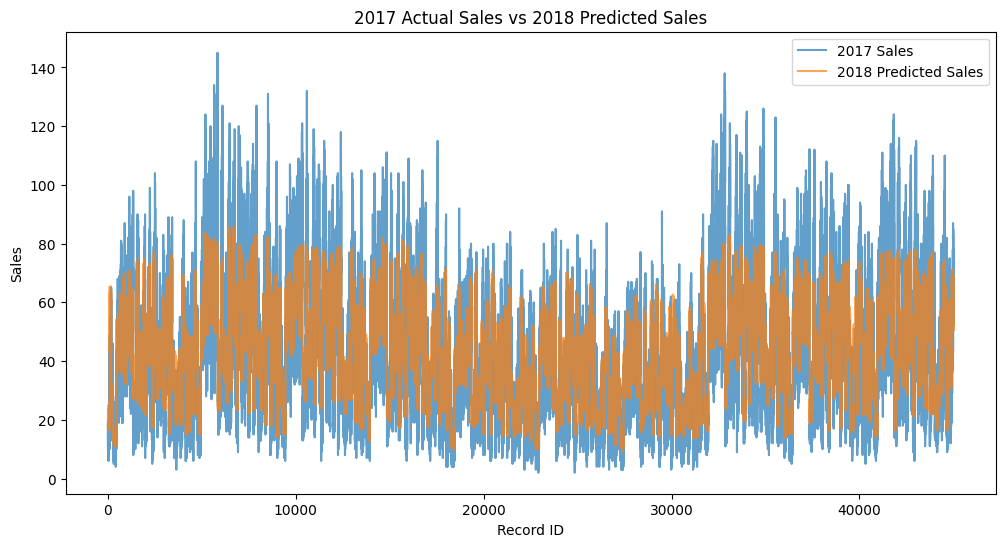

In [52]:
plt.figure(figsize=(12, 6))
plt.plot(compare_df['id'], compare_df['sales_2017'], label='2017 Sales', alpha=0.7)
plt.plot(compare_df['id'], compare_df['sales_2018'], label='2018 Predicted Sales', alpha=0.7)
plt.title('2017 Actual Sales vs 2018 Predicted Sales')
plt.xlabel('Record ID')
plt.ylabel('Sales')
plt.legend()
plt.show()

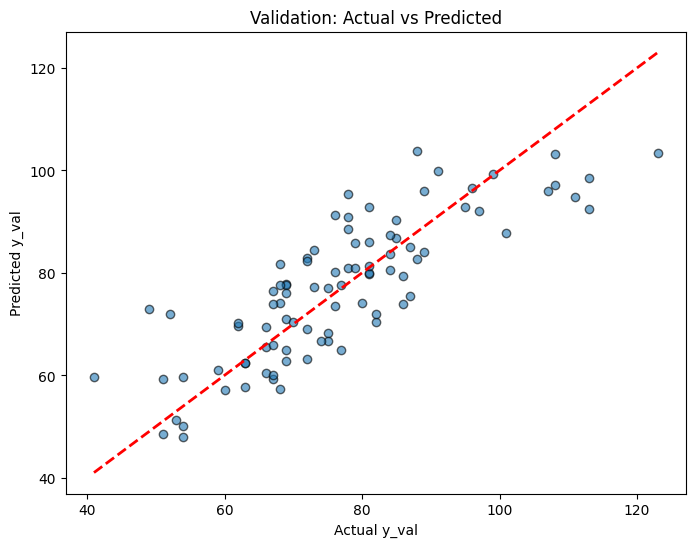

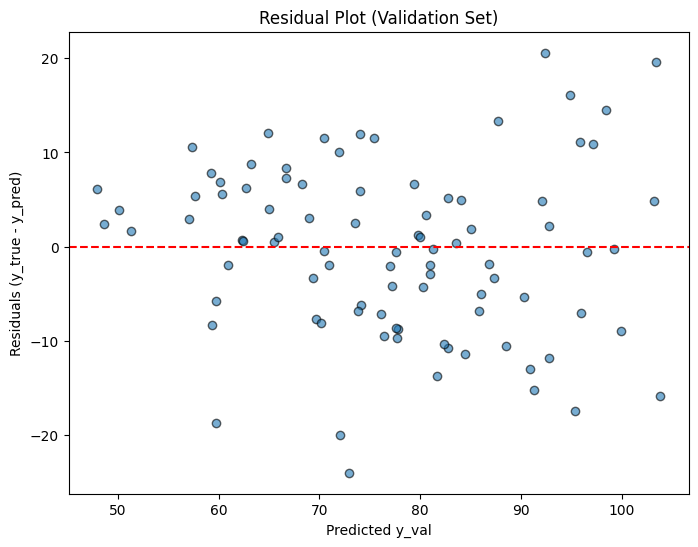

In [53]:
import matplotlib.pyplot as plt

# --- 1. Make predictions on the validation set ---
y_val_pred = xgb_model.predict(X_val)

# --- 2. Scatter plot: y_true vs y_pred ---
plt.figure(figsize=(8, 6))
plt.scatter(y_val, y_val_pred, alpha=0.6, edgecolors='k')
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)  # perfect prediction line
plt.xlabel("Actual y_val")
plt.ylabel("Predicted y_val")
plt.title("Validation: Actual vs Predicted")
plt.show()

# --- 3. (Optional) Residual plot ---
residuals = y_val - y_val_pred
plt.figure(figsize=(8, 6))
plt.scatter(y_val_pred, residuals, alpha=0.6, edgecolors='k')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Predicted y_val")
plt.ylabel("Residuals (y_true - y_pred)")
plt.title("Residual Plot (Validation Set)")
plt.show()


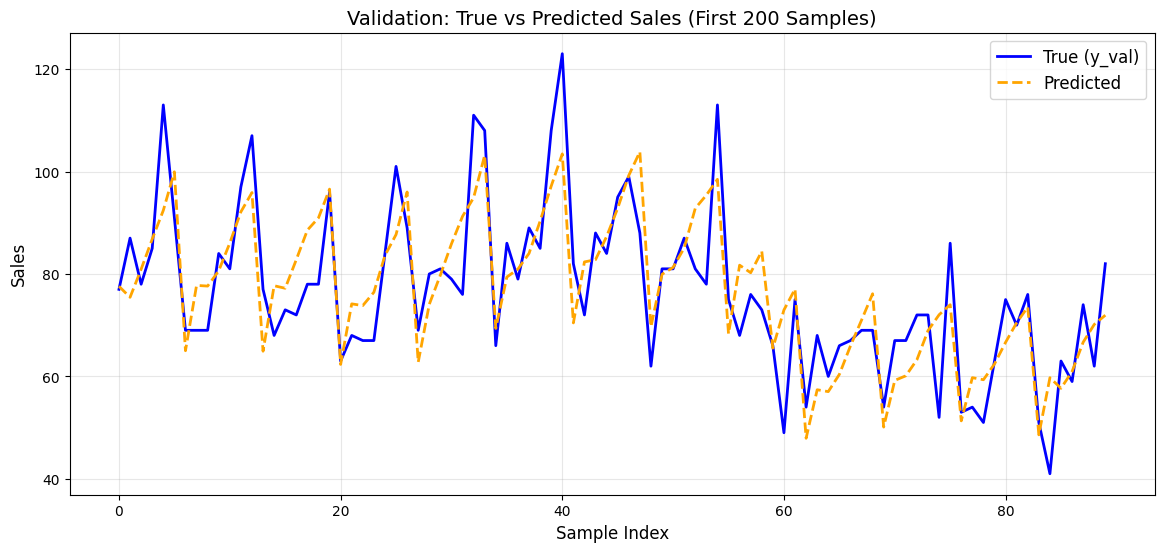

In [55]:
# =========================
# 📊 Plot: True vs Pred (Validation)
# =========================
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
plt.plot(y_val.values[:200], label="True (y_val)", color="blue", linewidth=2)
plt.plot(y_val_pred[:200], label="Predicted", color="orange", linestyle="--", linewidth=2)
plt.title("Validation: True vs Predicted Sales (First 200 Samples)", fontsize=14)
plt.xlabel("Sample Index", fontsize=12)
plt.ylabel("Sales", fontsize=12)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.show()